In [1]:
import pandas as pd
import seaborn as sns
import random
from os.path import join
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV

In [2]:
SEED = 111
random.seed(SEED)

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [3]:
data = pd.read_csv(join('..', 'data', "train.csv"))
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [5]:
data.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,17568.000000,17996.000000,17996.000000,15982.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04,17996.000000,17996.000000
mean,44.512124,0.543433,0.662777,5.952447,-7.910660,0.636753,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05,3.924039,6.695821
std,17.426928,0.166268,0.235373,3.196854,4.049151,0.480949,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05,0.361618,3.206073
min,1.000000,0.059600,0.000020,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01,1.000000,0.000000
25%,33.000000,0.432000,0.509000,3.000000,-9.538000,0.000000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05,4.000000,5.000000
50%,44.000000,0.545000,0.700000,6.000000,-7.016000,1.000000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05,4.000000,8.000000
75%,56.000000,0.659000,0.860000,9.000000,-5.189000,1.000000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


Данные не стандартизованы, но учитывая, что они будут использованы для дерева решений, не считаю нужным их стандартизовать.

In [6]:
data.isna().sum()

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

In [7]:
data.shape

(17996, 17)

array([[<Axes: title={'center': 'instrumentalness'}>]], dtype=object)

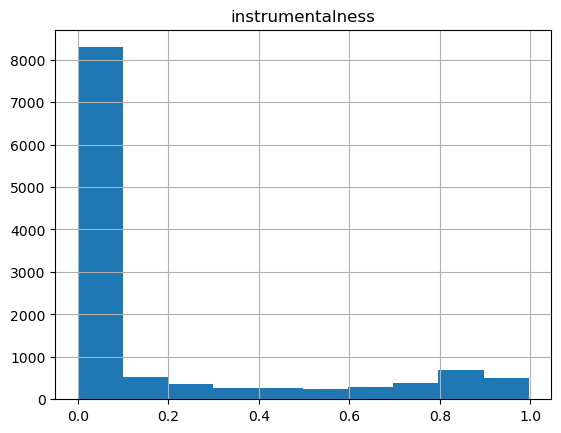

In [8]:
data.dropna()[['instrumentalness']].hist()

<Axes: >

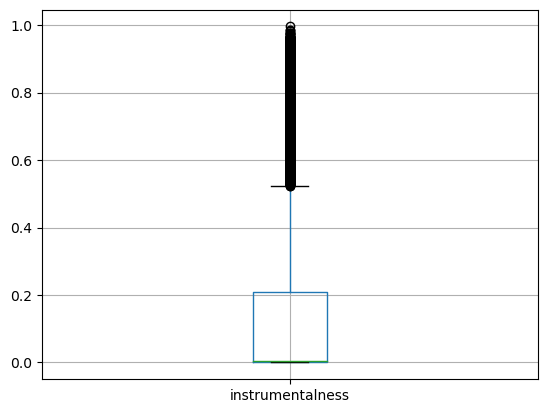

In [9]:
data.dropna()[['instrumentalness']].boxplot()

Видим, что очень большое количество пропущенных значений в переменной instrumentalness. Они будут нам мешать в дальнейшем. Кроме того, как видно выше, имеющиеся в переменной данные не очень хорошие. Вместо того, чтобы удалять четверть всех песен из датасета, разумнее просто удалить колонку instrumentalness, что мы и сделаем:

In [10]:
clean_data = data.drop(['instrumentalness'], axis = 1)

Теперь удалим строки с пропущенными значениями:

In [11]:
clean_data = clean_data.dropna()
clean_data.shape

(15613, 16)

Посмотрим на распределение данных в разных переменных:

In [12]:
import matplotlib.pyplot as plt

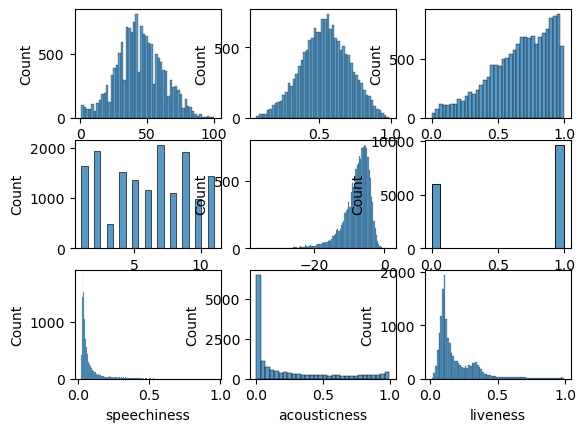

In [13]:
for i, column in enumerate(clean_data.iloc[:, 2:11].columns, 1):
    plt.subplot(3, 3 ,i)
    sns.histplot(clean_data[column])

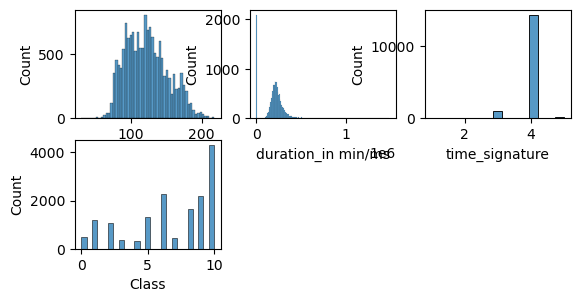

In [14]:
for i, column in enumerate(clean_data.iloc[:, 12:17].columns, 1):
    plt.subplot(3, 3 ,i)
    sns.histplot(clean_data[column])

Посмотрим поближе на особенно "выделяющиеся" графики:

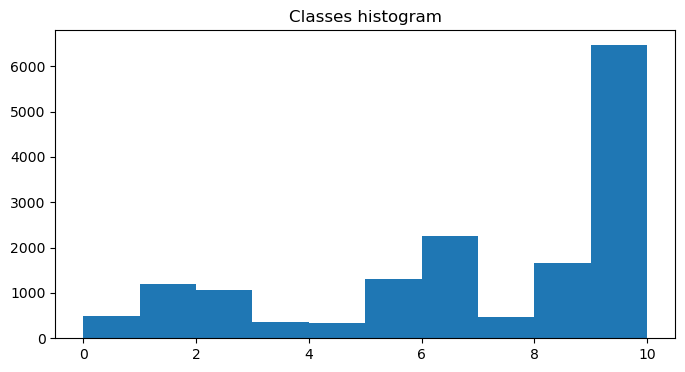

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.hist(clean_data['Class'])
plt.title("Classes histogram")
plt.show()

Отметим на будущее явный дисбаланс классов.

array([[<Axes: title={'center': 'speechiness'}>]], dtype=object)

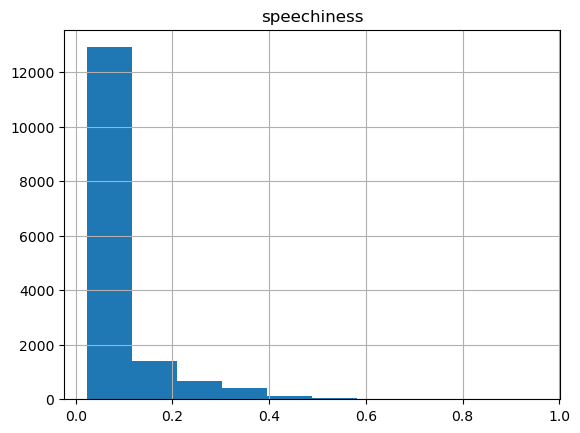

In [16]:
clean_data[['speechiness']].hist()

array([[<Axes: title={'center': 'acousticness'}>]], dtype=object)

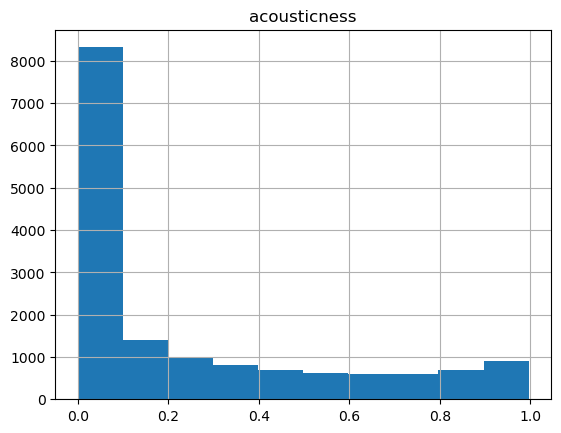

In [17]:
clean_data[['acousticness']].hist()

array([[<Axes: title={'center': 'liveness'}>]], dtype=object)

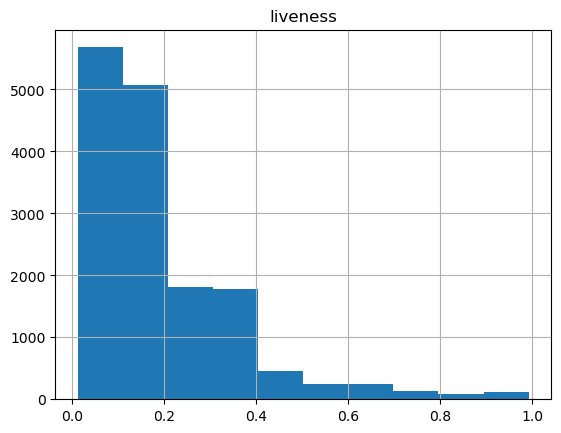

In [18]:
clean_data[['liveness']].hist()

array([[<Axes: title={'center': 'duration_in min/ms'}>]], dtype=object)

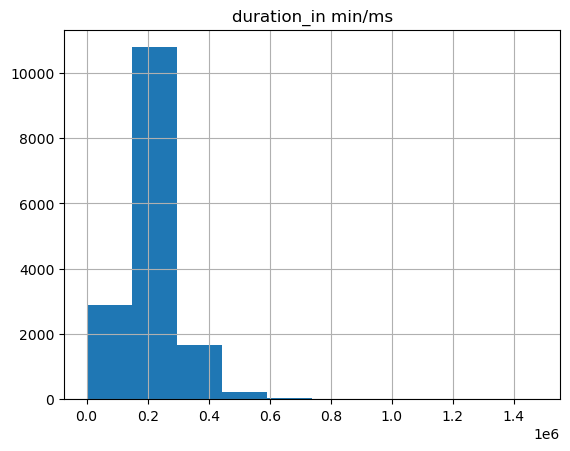

In [19]:
clean_data[['duration_in min/ms']].hist()

array([[<Axes: title={'center': 'time_signature'}>]], dtype=object)

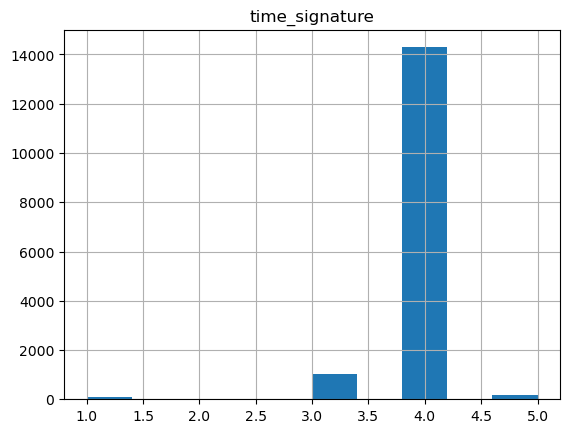

In [20]:
clean_data[['time_signature']].hist()

In [21]:
data_vif = clean_data.drop(columns = ['Artist Name', 'Track Name'])

In [22]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(data_vif.values, i) for i in range(data_vif.shape[1])]
vif['variable'] = data_vif.columns
vif

,VIF,variable
0,8.131326,Popularity
1,17.018873,danceability
2,28.650516,energy
3,4.487926,key
4,9.897365,loudness
5,2.648157,mode
6,2.106620,speechiness
7,3.481820,acousticness
8,2.684547,liveness
9,7.302490,valence


Если почти для всех записей переменная принимает одинаковое значение, то может быть оправданным убрать такую переменную, особенно если мы обратим внимание на значение VIF:

In [23]:
clean_data = clean_data.drop(['time_signature'], axis = 1)

In [24]:
data_vif = clean_data.drop(columns = ['Artist Name', 'Track Name'])
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(data_vif.values, i) for i in range(data_vif.shape[1])]
vif['variable'] = data_vif.columns
vif

,VIF,variable
0,7.875449,Popularity
1,13.882444,danceability
2,18.886027,energy
3,4.441203,key
4,7.810615,loudness
5,2.617781,mode
6,2.103297,speechiness
7,3.189018,acousticness
8,2.677685,liveness
9,7.258466,valence


Стало лучше. Выбрасывать некоторые другие переменные я не стал, т.к. в них может содержаться нужная нам информация, а проблемы с ними менее выражены.

Теперь построим боксплоты:

<Axes: >

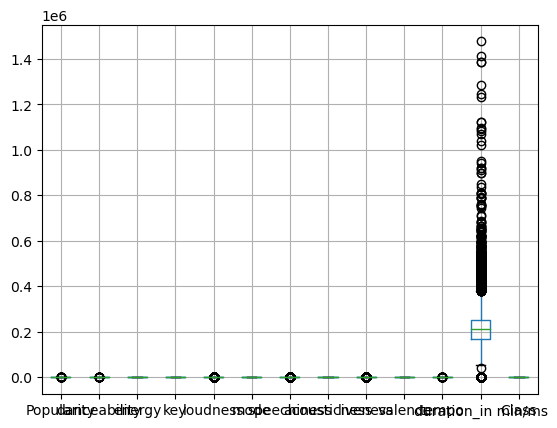

In [25]:
clean_data.boxplot()

Не очень информативно, попробуем посмотреть по отдельности:

<Axes: >

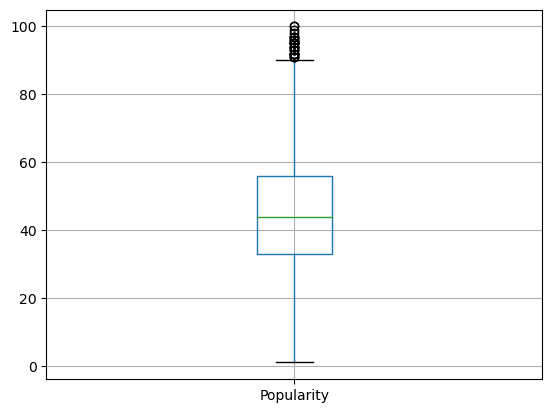

In [26]:
clean_data[['Popularity']].boxplot()

<Axes: >

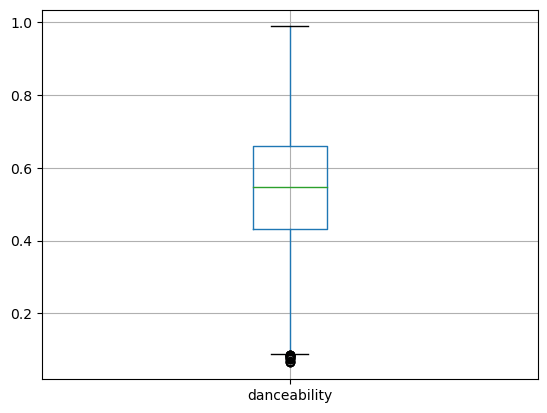

In [27]:
clean_data[['danceability']].boxplot()

<Axes: >

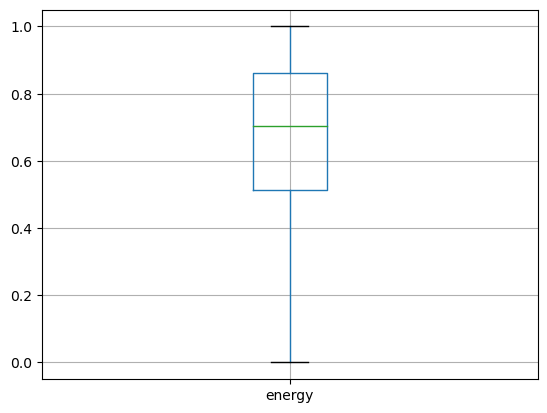

In [28]:
clean_data[['energy']].boxplot()

<Axes: >

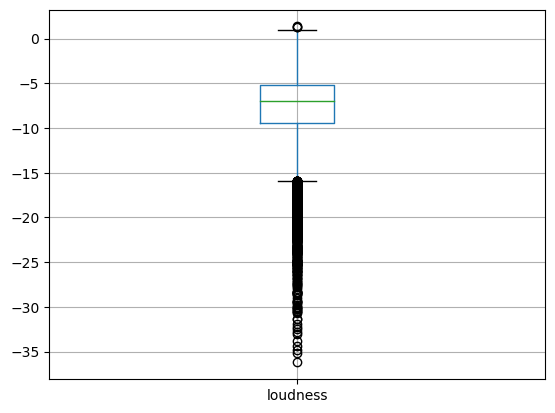

In [29]:
clean_data[['loudness']].boxplot()

<Axes: >

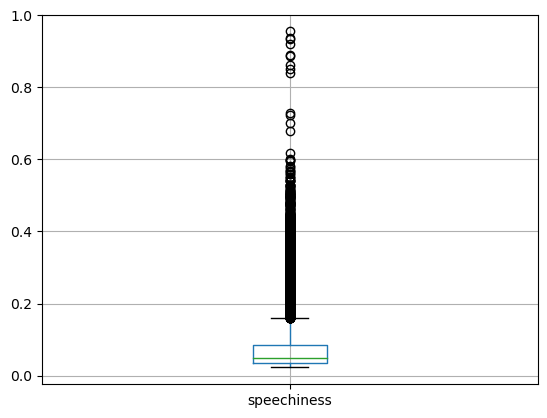

In [30]:
clean_data[['speechiness']].boxplot()

<Axes: >

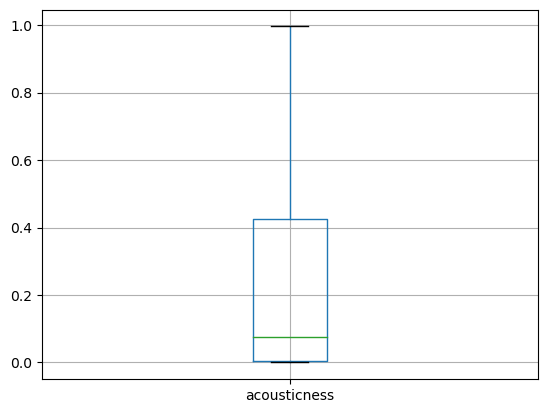

In [31]:
clean_data[['acousticness']].boxplot()

<Axes: >

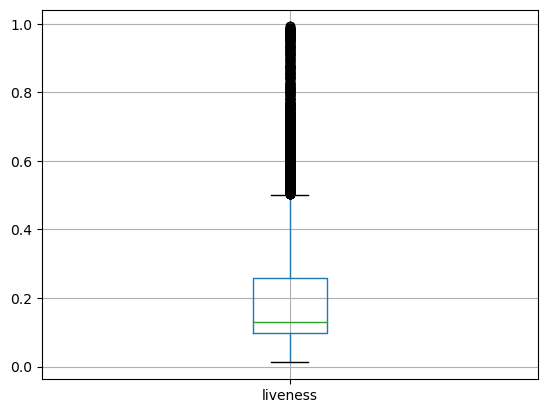

In [32]:
clean_data[['liveness']].boxplot()

<Axes: >

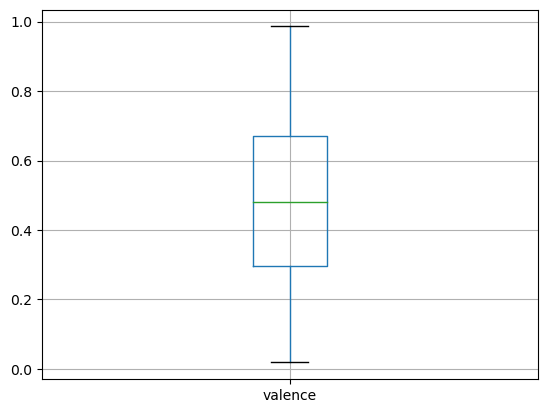

In [33]:
clean_data[['valence']].boxplot()

<Axes: >

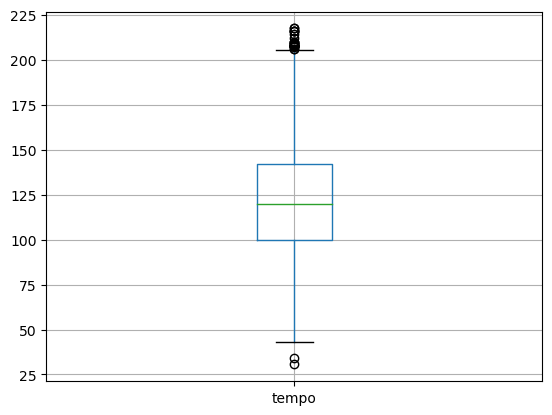

In [34]:
clean_data[['tempo']].boxplot()

<Axes: >

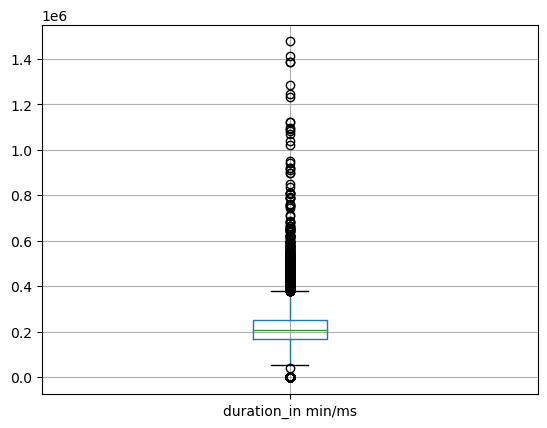

In [35]:
clean_data[['duration_in min/ms']].boxplot()

Мы видим то, что можно счесть за многочисленные выбросы. Однако, нужно помнить, что мы говорим об особенностях музыкальных композиций, и эти "выбросы" могут нести важную информацию, а не являться какими-то ошибками (что, кстати, потенциально может подтверждаться их многочисленностью и "равномерностью" распределения, то есть мы не видим несколько сильно выбивающихся значений). Удаление не считаю оправданным.

Теперь посмотрим на то, как коррелируют переменные между собой:

In [36]:
data_cor = clean_data.drop(columns = ['Artist Name', 'Track Name'])
data_cor.corr().style.background_gradient(cmap = 'Reds')

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo,duration_in min/ms,Class
Popularity,1.000000,0.167841,0.049912,0.005901,0.128904,0.014927,0.034451,-0.128204,-0.074121,0.055601,-0.004236,-0.028111,0.156755
danceability,0.167841,1.000000,-0.107789,0.007082,0.049396,-0.068680,0.203774,0.017916,-0.105875,0.444102,-0.187918,-0.128275,-0.104809
energy,0.049912,-0.107789,1.000000,0.015435,0.762748,-0.036950,0.124470,-0.743266,0.191197,0.210236,0.204699,0.241118,0.210718
key,0.005901,0.007082,0.015435,1.000000,0.002787,-0.111741,0.001881,-0.009717,0.015091,0.030430,0.012491,0.013494,-0.008763
loudness,0.128904,0.049396,0.762748,0.002787,1.000000,-0.038943,0.095718,-0.605532,0.105653,0.170883,0.157005,0.163787,0.175312
mode,0.014927,-0.068680,-0.036950,-0.111741,-0.038943,1.000000,-0.067925,0.026868,-0.006292,-0.009946,0.016785,-0.069994,-0.044157
speechiness,0.034451,0.203774,0.124470,0.001881,0.095718,-0.067925,1.000000,-0.086722,0.071345,0.054440,0.043878,-0.002812,-0.067720
acousticness,-0.128204,0.017916,-0.743266,-0.009717,-0.605532,0.026868,-0.086722,1.000000,-0.107990,-0.114044,-0.161297,-0.320331,-0.233007
liveness,-0.074121,-0.105875,0.191197,0.015091,0.105653,-0.006292,0.071345,-0.107990,1.000000,0.015657,0.023245,0.055559,0.038376
valence,0.055601,0.444102,0.210236,0.030430,0.170883,-0.009946,0.054440,-0.114044,0.015657,1.000000,0.045714,-0.108980,-0.080707


Считаю, что следует удалить energy, оно сильно коррелирует с loudness (и в некоторой степени с другими переменными):

In [37]:
data_cor.drop(columns = ['energy']).corr().style.background_gradient(cmap = 'Reds')

,Popularity,danceability,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo,duration_in min/ms,Class
Popularity,1.000000,0.167841,0.005901,0.128904,0.014927,0.034451,-0.128204,-0.074121,0.055601,-0.004236,-0.028111,0.156755
danceability,0.167841,1.000000,0.007082,0.049396,-0.068680,0.203774,0.017916,-0.105875,0.444102,-0.187918,-0.128275,-0.104809
key,0.005901,0.007082,1.000000,0.002787,-0.111741,0.001881,-0.009717,0.015091,0.030430,0.012491,0.013494,-0.008763
loudness,0.128904,0.049396,0.002787,1.000000,-0.038943,0.095718,-0.605532,0.105653,0.170883,0.157005,0.163787,0.175312
mode,0.014927,-0.068680,-0.111741,-0.038943,1.000000,-0.067925,0.026868,-0.006292,-0.009946,0.016785,-0.069994,-0.044157
speechiness,0.034451,0.203774,0.001881,0.095718,-0.067925,1.000000,-0.086722,0.071345,0.054440,0.043878,-0.002812,-0.067720
acousticness,-0.128204,0.017916,-0.009717,-0.605532,0.026868,-0.086722,1.000000,-0.107990,-0.114044,-0.161297,-0.320331,-0.233007
liveness,-0.074121,-0.105875,0.015091,0.105653,-0.006292,0.071345,-0.107990,1.000000,0.015657,0.023245,0.055559,0.038376
valence,0.055601,0.444102,0.030430,0.170883,-0.009946,0.054440,-0.114044,0.015657,1.000000,0.045714,-0.108980,-0.080707
tempo,-0.004236,-0.187918,0.012491,0.157005,0.016785,0.043878,-0.161297,0.023245,0.045714,1.000000,0.040217,0.033104


Стало лучше. Коррелирующие переменные остались, однако в меньшей степени, и не считаю разумным дальнейшее выбрасывание переменных:

In [38]:
clean_data = clean_data.drop(['energy'], axis = 1)

In [39]:
model_data = clean_data.drop(columns = ['Artist Name', 'Track Name'])

Последнее, что осталось - перекодировать переменную key:

In [40]:
pd.get_dummies(model_data, columns = ['key']).iloc[:, 11:22]

,key_1.0,key_2.0,key_3.0,key_4.0,key_5.0,key_6.0,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0
0,True,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,False
4,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
17991,False,False,False,False,False,False,True,False,False,False,False
17992,False,False,False,False,False,False,False,False,False,False,True
17993,False,False,False,True,False,False,False,False,False,False,False
17994,False,False,False,False,False,True,False,False,False,False,False


In [41]:
model_data = pd.get_dummies(model_data, columns = ['key'])

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Данные мы уже предобработали в прошлом задании.
Т.к. мы будем использовать кросс-варидацию, делим просто на train и test:

In [42]:
X_train, X_test, y_train, y_test = train_test_split(model_data.drop('Class', axis = 1), model_data['Class'], test_size=0.3)

In [43]:
my_first_tree = DecisionTreeClassifier(class_weight = 'balanced') # помним про дисбаланс классов!

In [44]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': list(range(1, 15)),
    'min_samples_split': [2, 3, 4, 5, 6, 7],
    'min_samples_leaf': list(range(1, 20)),
    'random_state': [SEED]
}

In [45]:
gridsearch = GridSearchCV(my_first_tree, param_grid = param_grid, scoring = 'balanced_accuracy', n_jobs = -1)

In [46]:
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19],
                         'min_samples_split': [2, 3, 4, 5, 6, 7],
                         'random_state': [111],
                         'splitter': ['best', 'random']},
             scoring='balanced_accuracy')

In [47]:
print(f'Best hyperparameters are: {gridsearch.best_params_}\n\nBest balanced accuracy score is {gridsearch.best_score_}')

Best hyperparameters are: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 2, 'random_state': 111, 'splitter': 'best'}

Best balanced accuracy score is 0.5113127071182143


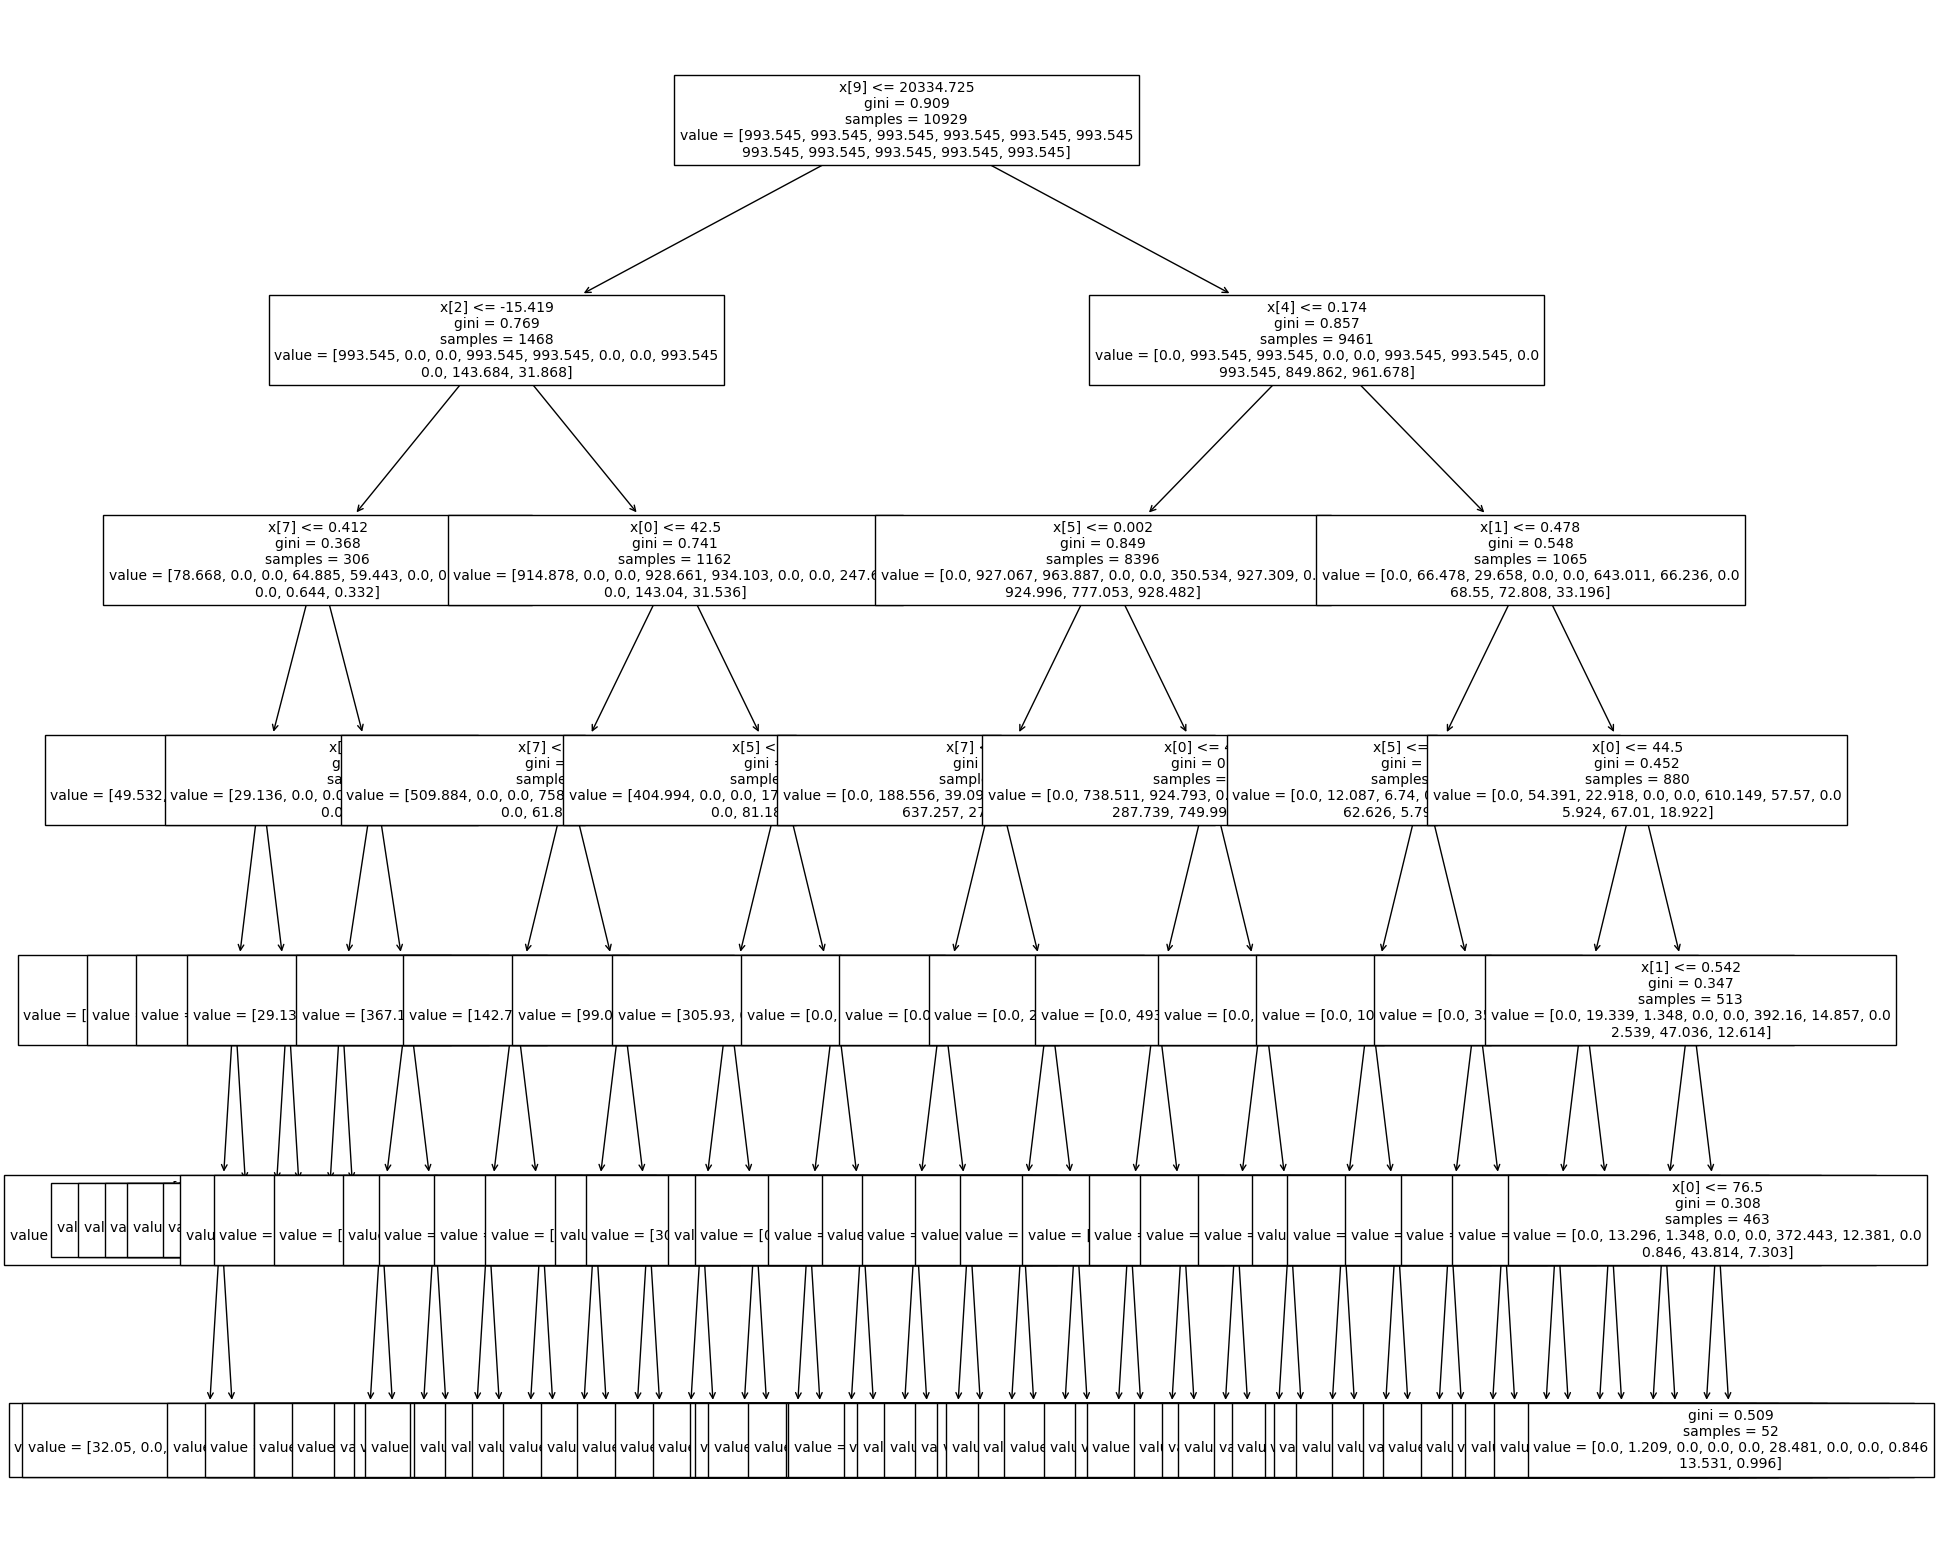

In [48]:
my_first_tree = DecisionTreeClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 6, min_samples_leaf = 1, min_samples_split = 2, random_state = 111, splitter = 'best')
my_first_tree.fit(X_train, y_train)
plt.figure(figsize=(20,20))
tree.plot_tree(my_first_tree, fontsize = 10)
plt.show()

In [49]:
balanced_accuracy_score(y_test, my_first_tree.predict(X_test))

0.5253397063718134

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

Желание есть, сил и времени - нету :'( ...

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

Ну, думаю, про фильмы много кто напишет, поэтому расскажу про мультики! Анимацию вообще обычно как-то обходят вниманием, а очень зря!

1. Avatar the last airbender. Абсолютно потрясающая вещь, объединяющая в себе креативную анимацию, детский веселый эскапизм (очень нужная вещь, особенно в наше-то время...) и, местами, удивительную психологическую и философскую глубину. Лично меня сначала отталкивала некоторая "ребяческость", за неимением лучшего слова (что неудивительно, так-то мультик рассчитаный в первую очередь на детскую аудиторию). Но если просто принять это, то и взрослый человек может найти там много что и подумать, и особенно почувствовать.

2. Samurai Jack. Не сказать, чтобы мультик про самурая, который кромсает роботов в дистопичном будущем, был нагружен глубоким сюжетом (после первых серий он эпизодичен), но какая же это анимация! При том, что стиль достаточно минималистичен, Тартаковский на глубинном уровне понимает суть и сильные стороны анимации, и виртуозно с ними работает. Это сложно как-то рассказать словами, это надо просто увидеть. Лично я получил огромное в первую очередь эстетическое удовольствие от просмотра. Наверное, серия, лучше всего это иллюстрирующая, это 'Jack and the Three Blind Archers' (это просто произведение искусства, честно скажу), хотя я бы все же смотрел по-порядку. При всей эпизодичности и незамысловатости сюжета, у мультфильма есть определенная психологическая и ценностная, что ли, глубина, которая притягивает.
Если интересно, у Тартаковского еще есть Primal, тоже эстетическая, концептуальная вещь с оригинальной анимацией. Ну и очень хороший пример того, как можно рассказать сложную эмоциональную историю без единого слова диалога.

3. Наверное, уже понятно, что я очень люблю креативную и умело используемую анимацию. Трудно выбрать, что здесь написать (много хороших вариантов), но если из недавнего, то все же наверное Puss in boots: the last wish. Ничего не буду добавлять, просто посоветую посмотреть.

Кстати, знаю что многие любят смотреть вещи в переводе, даже зная язык, но советую смотреть оригиналы. Конкретно про эти не знаю, но даже удивительно, сколько всего в переводе можно потерять, и как переведенное произведение нередко становится посредственным.

P.S. Я исчерпал лимит, но не могу написать про мультики, не сказав, что Миядзаки - гений. Вот.